<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/randomforest/clasificacion/01_carseats_randomforest_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import multiprocessing

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import GridSearchCV, ParameterGrid

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style='darkgrid')

In [3]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        ax.text(p.get_x()+p.get_width()/2., height + 1,height, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

# **Description**
---
El conjunto de datos `Carseats` contiene información sobre la venta de sillas infantiles en 400 tiendas distintas.

# **Objetivo**
---
Generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Ventas > 8) o bajas (Ventas <= 8) en función de todas las variables disponibles.


# **Diccionario de datos**
---

- `Sales`: ventas unitarias (en miles) en cada ubicación
- `CompPrice`: precio cobrado por el competidor en cada ubicación
- `Income`: nivel de ingresos de la comunidad (en miles de dólares)
- `Advertising`: presupuesto de publicidad local para la empresa en cada ubicación (en miles de dólares)
- `Population`: tamaño de la población en la región (en miles)
- `Price`: precio de los cargos de la compañía por los asientos de seguridad en cada sitio
- `ShelveLoc`: un factor con niveles que Badindica la calidad de la ubicación de las estanterías para los asientos de automóvil en cada sitio good and medium
- `Age`: edad media de la población local
- `Education`: nivel de educación en cada lugar
- `Urban`: un factor con niveles No o yes para indicar si la tienda está en una zona urbana o rural
- `US`: un factor con niveles No o yes para indicar si la tienda está en USA o no















# **data**
---

In [4]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
data = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: Carseats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   .. code:: R

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``, ``Good

In [5]:
data.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


- El conjunto de datos es de regresión, por lo tanto para trabajar la clasificación se procede a categorizar las ventas, en ventas altas y ventas bajas.

In [6]:
data['ventas_altas'] = np.where(data.Sales > 8, 1, 0)
data.drop('Sales', axis=1, inplace=True)
data.head(5)

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ventas_altas
0,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,117,100,4,466,97,Medium,55,14,Yes,Yes,0
4,141,64,3,340,128,Bad,38,13,Yes,No,0


# **Split**
---

In [7]:
X = data.drop('ventas_altas', axis = 1)
y = data['ventas_altas']

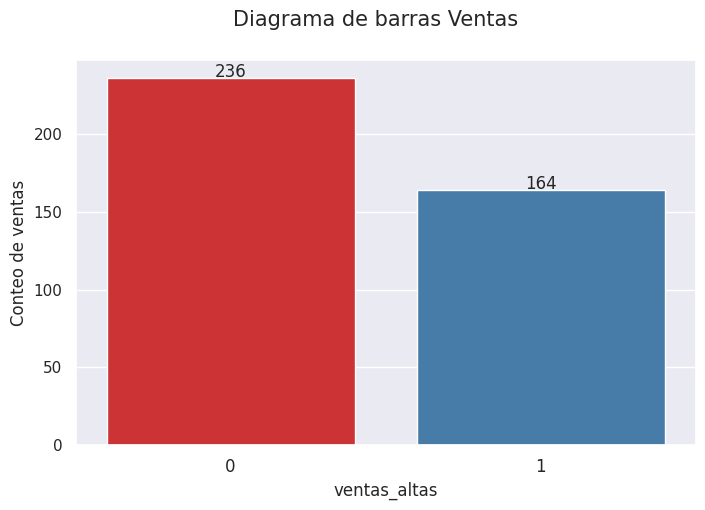

In [8]:
plot_bar(
    data, paleta=None,
    ejeX='ventas_altas',
    ejey='Conteo de ventas',
    title='Ventas')

- Ventas bajas : 0
- Ventas altas: 1

Hay un desbalance en el conjunto de datos del 59% registros son para ventas bajas y 41% son para ventas altas.



In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state = 1234,
    shuffle=True)

# **Transform data**
---

In [10]:
cat_cols = X_train.select_dtypes(
    include=['object']
).columns.to_list()

In [11]:
numeric_cols = X_train.select_dtypes(
    include=['float64', 'int64']
).columns.to_list()

In [12]:
preprocesor = ColumnTransformer(
    [('onehot',
      OneHotEncoder(handle_unknown='ignore',
                    sparse_output=False,
                    drop='if_binary'),
      cat_cols)],
    remainder='passthrough'
)

In [13]:
preprocesor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['ShelveLoc', 'Urban', 'US'])])

In [14]:
X_train_prep = preprocesor.fit_transform(X_train)
X_test_prep = preprocesor.transform(X_test)

In [15]:
encoded_cat = preprocesor.named_transformers_['onehot'].get_feature_names_out(
    cat_cols)

encoded_cat

array(['ShelveLoc_Bad', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_Yes',
       'US_Yes'], dtype=object)

In [16]:
labels = np.concatenate([
    numeric_cols, encoded_cat
])

labels

array(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education', 'ShelveLoc_Bad', 'ShelveLoc_Good', 'ShelveLoc_Medium',
       'Urban_Yes', 'US_Yes'], dtype=object)

In [17]:
X_train = pd.DataFrame(X_train_prep, columns=labels)
X_test  = pd.DataFrame(X_test_prep, columns=labels)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         280 non-null    float64
 1   Income            280 non-null    float64
 2   Advertising       280 non-null    float64
 3   Population        280 non-null    float64
 4   Price             280 non-null    float64
 5   Age               280 non-null    float64
 6   Education         280 non-null    float64
 7   ShelveLoc_Bad     280 non-null    float64
 8   ShelveLoc_Good    280 non-null    float64
 9   ShelveLoc_Medium  280 non-null    float64
 10  Urban_Yes         280 non-null    float64
 11  US_Yes            280 non-null    float64
dtypes: float64(12)
memory usage: 26.4 KB


In [18]:
X_train

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,0.0,0.0,1.0,0.0,0.0,106.0,44.0,0.0,481.0,111.0,70.0,14.0
1,0.0,0.0,1.0,0.0,1.0,134.0,27.0,18.0,467.0,96.0,49.0,14.0
2,0.0,0.0,1.0,1.0,0.0,116.0,37.0,0.0,426.0,90.0,76.0,15.0
3,1.0,0.0,0.0,0.0,1.0,134.0,82.0,7.0,473.0,112.0,51.0,12.0
4,0.0,0.0,1.0,1.0,1.0,136.0,119.0,6.0,178.0,145.0,35.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.0,0.0,1.0,1.0,0.0,155.0,80.0,0.0,237.0,124.0,37.0,14.0
276,0.0,0.0,1.0,1.0,1.0,109.0,64.0,13.0,39.0,119.0,61.0,17.0
277,0.0,1.0,0.0,1.0,1.0,148.0,76.0,3.0,126.0,99.0,60.0,11.0
278,0.0,0.0,1.0,1.0,1.0,117.0,118.0,14.0,445.0,120.0,32.0,15.0


En la implementación de RandomForestClassifier, la métrica devuelta como oob_score es el accuracy, si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés.

# **Grid Search basado en out-of-bag score**
---


In [19]:
parama_grid = ParameterGrid(
    {
        'n_estimators': [50, 100, 150],
        'max_features': [5, 7, 9],
        'max_depth'   : [None, 3, 10, 20],
        'criterion'   : ['gini', 'entropy']
    }
)


In [20]:
response = {'params': [], 'oob_accuracy': []}

for params  in parama_grid:
  model = RandomForestClassifier(
      oob_score = True,
      n_jobs    = -1,
      random_state = 123,
      **params

  )
  model.fit(X_train, y_train)
  response['params'].append(params)
  response['oob_accuracy'].append(model.oob_score_)
  print(f"Modelo: {params} \u2713")


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {

In [21]:
resutado = pd.DataFrame(response)
resutado = pd.concat([resutado, resutado['params'].apply(pd.Series)], axis = 1)
resutado = resutado.sort_values('oob_accuracy', ascending=False)
resutado = resutado.drop(columns = 'params')
resutado.head(4)

,oob_accuracy,criterion,max_depth,max_features,n_estimators
41,0.803571,entropy,NaN,7,150
68,0.803571,entropy,20.0,7,150
3,0.796429,gini,NaN,7,50
67,0.796429,entropy,20.0,7,100


In [22]:
print(f'''
Los mejores hiperparametros (oob-accuracy) son
{resutado.iloc[0, 0]}, {resutado.iloc[0,:]["oob_accuracy"]}, accuracy''')


Los mejores hiperparametros (oob-accuracy) son
0.8035714285714286, 0.8035714285714286, accuracy


In [23]:
# VERSIÓN PARALELIZADA
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params
    )

    modelo.fit(X, y)

    if verbose:
        print(f"Modelo: {params} \u2713")

    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(
                    X_train_prep,
                    y_train,
                    RandomForestClassifier(),
                    params) for params in param_grid]
             )

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
22,0.803571,entropy,20.0,7,150
13,0.803571,entropy,NaN,7,150
12,0.792857,entropy,NaN,5,150
1,0.792857,gini,NaN,7,150


In [24]:
print(f'Los mejores hiperparametros (oob-accuracy) son {resultados.iloc[0, 0]}, {resultados.iloc[0,:]["oob_accuracy"]}, accuracy')

Los mejores hiperparametros (oob-accuracy) son 0.8035714285714286, 0.8035714285714286, accuracy


# **Grid Search basado en validación cruzada**
---

In [25]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [5, 7, 9],
    'max_depth': [None, 3, 10, 20],
    'criterion': ['gini', 'entropy']
}


grid = GridSearchCV(
    estimator = RandomForestClassifier(random_state=12354),
    param_grid = param_grid,
    scoring = 'recall',
    n_jobs     = multiprocessing.cpu_count() - 1,
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
    refit      = True,
    verbose    = 0,
    return_train_score = True

)

grid.fit(X_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=12354), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': [5, 7, 9],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='recall')

In [26]:
respuesta = pd.DataFrame(grid.cv_results_)
respuesta.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
35,gini,20,9,150,0.712847,0.103405,1.0,0.0
8,gini,None,9,150,0.712847,0.103405,1.0,0.0
68,entropy,20,7,150,0.712190,0.085191,1.0,0.0
41,entropy,None,7,150,0.712190,0.085191,1.0,0.0


In [27]:
# Como se escogio la metrica del recall por el desbalance vario el resultado
print(f'''
Los mejores hiperparametros (cv) son:
{grid.best_params_}, {grid.best_score_}, {grid.scoring}''')


Los mejores hiperparametros (cv) son:
{'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150}, 0.7128472364315298, recall


# **Prediccion**
---

In [28]:
final_model = grid.best_estimator_

In [29]:
y_pred = final_model.predict(X_test)

In [30]:
def matrix_confusion(
    y_true:pd.Series,
    y_pred:pd.Series,
    churm:str='True',
    no_churm:str='False',
    title:str='Matriz de confusion',
    x_size:int=6,
    y_size:int=5,
    **kwards)->np.ndarray:
    """confusion matrix"""
    try:
      matrix = metrics.confusion_matrix(y_true, y_pred)
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(x_size, y_size))
      sns.heatmap(matrix, annot=True, ax=ax, fmt='g', **kwards)
      ax.set_title(title,size=20)
      ax.xaxis.set_ticklabels([no_churm,churm])
      ax.yaxis.set_ticklabels([no_churm,churm])
      ax.tick_params(labelsize = 12)
      fig.show()
      return matrix
    except Exception as e:
      print(e)

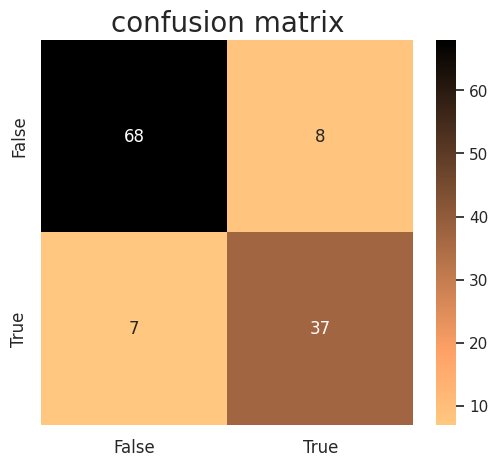

In [31]:
kward={"cmap":"RdBu",  "annot_kws":{'size': 12}}
kward={"cmap":plt.cm.copper_r,  "annot_kws":{'size': 12}}
amatrix = matrix_confusion(y_test, y_pred, title='confusion matrix', **kward)

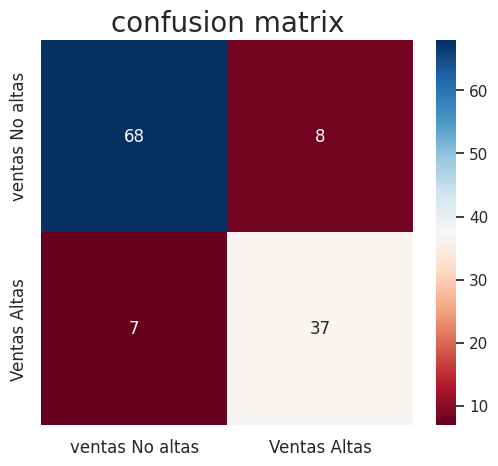

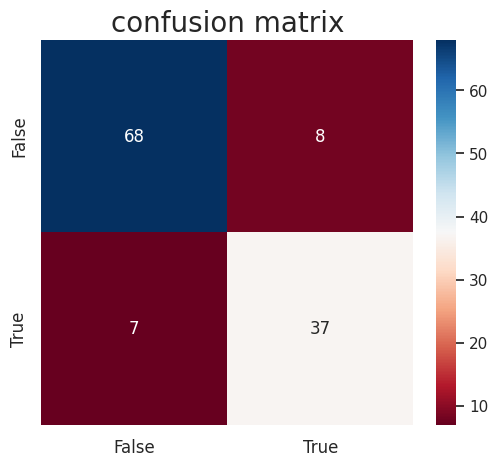

In [32]:
kward={"cmap":"RdBu",  "annot_kws":{'size': 12}}
#kward={"cmap":plt.cm.copper_r,  "annot_kws":{'size': 12}}
amatrix = matrix_confusion(
    y_test,
    y_pred,
    title='confusion matrix',
    churm='Ventas Altas',
    no_churm='ventas No altas', **kward)
amatrix = matrix_confusion(y_test, y_pred, title='confusion matrix', **kward)

A partir de la matriz, el modelo parece tener un buen comportamiento en la predicción de las ubicaciones donde habra altas ventas de las sillas de bebe para coche. Es bueno para determinar cuales son las ventas altas y cuales no.


In [33]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        76
           1       0.82      0.84      0.83        44

    accuracy                           0.88       120
   macro avg       0.86      0.87      0.87       120
weighted avg       0.88      0.88      0.88       120



El modelo tiene un buen rendimiento del 81% de la sensibilidad y el 80 en la media armonica entre la sensibilidad y le precición, tras optimizar los hiperparametros.

# **Prediccion Probabilidades**
---

In [38]:
y_pred = final_model.predict(X_test_prep)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0])

In [40]:
y_pred = final_model.predict_proba(X_test_prep)
y_pred[:5, :]

array([[0.78666667, 0.21333333],
       [0.52      , 0.48      ],
       [0.96      , 0.04      ],
       [0.52666667, 0.47333333],
       [0.42      , 0.58      ]])

In [41]:
fracciones = pd.DataFrame(data=y_pred, columns=['0', '1'])
fracciones['clasificacion_default_0.5'] = np.where(
    fracciones['0'] > fracciones['1'], 0, 1)
fracciones.head(3)

,0,1,clasificacion_default_0.5
0,0.786667,0.213333,0
1,0.520000,0.480000,0
2,0.960000,0.040000,0


Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se preve que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.

In [43]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ==============================================================================
fracciones['clasificacion_custom_0.8'] = np.where(fracciones['1'] > 0.8, 1, 0)
fracciones.iloc[4:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
4,0.420000,0.580000,1,0
5,0.906667,0.093333,0,0
6,0.473333,0.526667,1,0
7,0.200000,0.800000,1,0
8,0.180000,0.820000,1,1
9,0.533333,0.466667,0,0
